### 1) loading the dataset

In [1]:
from translation_machine import dataset_mod,sentence_mod

import numpy as np
import torch

language_info = torch.load("../models/language_info.pth")

vocab_french = language_info["french"]["vocab"]
vocab_english = language_info["english"]["vocab"]

max_length_french = language_info["french"]["max_sentence_train_val"]
max_length_english = language_info["english"]["max_sentence_train_val"]


whole_dataset = dataset_mod.DatasetFromTxt("../data/french_english_dataset/fra.txt")

whole_dataset = list(dataset_mod.SentenceDataSet(whole_dataset,sentence_type_src=sentence_mod.EnglishSentence,sentence_type_dst=sentence_mod.FrenchSentence))

# Remark : the responsability to split the dataset is done outside of this notebook

idxs_train = np.load("../dataset_splitting/idx_train.npy")
idxs_val = np.load("../dataset_splitting/idx_val.npy")
idxs_test = np.load("../dataset_splitting/idx_test.npy")

train_dataset = torch.utils.data.Subset(whole_dataset,idxs_train)
val_dataset = torch.utils.data.Subset(whole_dataset,idxs_val)
test_dataset = torch.utils.data.Subset(whole_dataset,idxs_test)

/home/amine_ammor_91/miniconda3/envs/trans_mach_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amine_ammor_91/miniconda3/envs/trans_mach_env/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
/home/amine_ammor_91/miniconda3/envs/trans_mach_env/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "fr" could not be loaded, trying "fr_core_news_sm" instead
  warnings.warn(


### 2) creation the vocabulary

In [5]:
from translation_machine import collate_fn_mod

import torch
from torch.utils.data import DataLoader
import numpy as np

collate_fn = collate_fn_mod.get_collate_fn(max_length_english,max_length_french)

batch_size= 128

train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)


In [6]:
len(vocab_french.vocab.itos_),len(vocab_english.vocab.itos_)

(5407, 4076)

In [7]:
from translation_machine import model_mod,model_bidirectionnal_mod



bidirectional_encoder = True
en_embeddings_size = 128
fr_embeddings_size = 128

hidden_size_encoder = 256

nb_directions = (2 if bidirectional_encoder else 1)

hidden_size_decoder = 256*nb_directions


model_inputs = {
    "embeddings_src_size":en_embeddings_size,
    "embeddings_tgt_size":fr_embeddings_size,
    "hidden_size_encoder":hidden_size_encoder,
    "hidden_size_decoder":hidden_size_decoder,
    "vocab_src":vocab_english,
    "vocab_tgt":vocab_french,
    "length_src_sentence":max_length_english,
    "length_tgt_sentence":max_length_french,
    "bidirectional_encoder":bidirectional_encoder
}

sequence_translator = model_bidirectionnal_mod.SequenceTranslator(**model_inputs)


In [8]:
from torch import optim
from translation_machine import model_trainer

from torch import nn
from torch import nn
baseline_loss = nn.CrossEntropyLoss(reduction="sum")

optimizer = optim.NAdam(params=sequence_translator.parameters(),lr=0.5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
model_trainer = model_trainer.ModelTrainer(sequence_translator,optimizer,scheduler,train_data_loader,val_data_loader,baseline_loss)


In [9]:
from tqdm import tqdm
sequence_translator.train()
losses_on_train = []
losses_on_val = []
metrics_on_train = []
metrics_on_val = []

In [37]:
from pathlib import Path
import torch
load_from_backup = True
path_model_and_dependencies = "../models/sequence_translator_bidirectionnal.pth"

if load_from_backup and Path(path_model_and_dependencies).exists():
    back_up = torch.load(path_model_and_dependencies)
    sequence_translator.load_state_dict(back_up["model_params"])
    scheduler.load_state_dict(back_up["scheduler"])
    optimizer.load_state_dict(back_up["optimizer"])
    losses_train_and_weights = back_up["losses_with_weights"]["train"]
    losses_val_and_weights = back_up["losses_with_weights"]["val"]
    metrics_on_train = back_up["metrics"]["train"]
    metrics_on_val = back_up["metrics"]["val"]
    print("model loaded")

model loaded


In [39]:
optimizer

NAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    foreach: None
    initial_lr: 0.5
    lr: 0.0008086546349614951
    momentum_decay: 0.004
    weight_decay: 0
)

  0%|                                                                                   | 0/20 [00:00<?, ?it/s]

optimizing for epoch 0
training_step
0 3.034505345568086
100 3.033632094070787
200 3.1105942895729943
300 3.235927150994783
400 3.1256994995811334
500 3.168358702667814
600 3.192782447451637
700 3.231854889234162
800 3.217045077865017
900 3.467782192339038
1000 3.4522976012233824
validation_step
0 9.61551029265873
100 10.505823537844037
saving for epoch 0


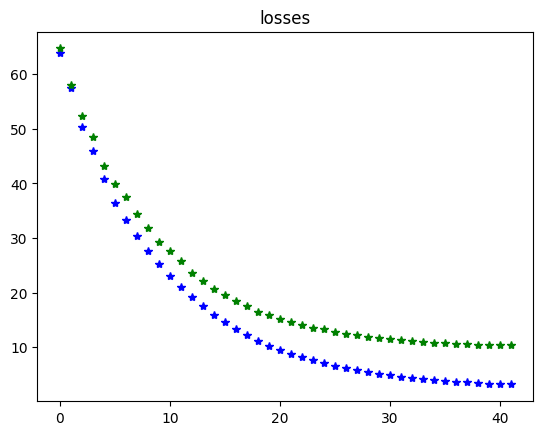

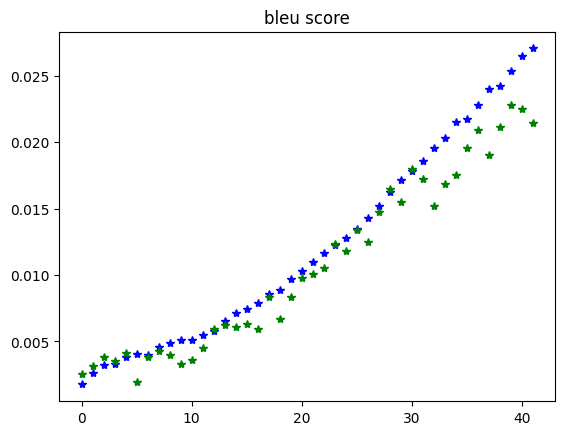

  5%|███▌                                                                    | 1/20 [03:35<1:08:20, 215.84s/it]

215.83632349967957
optimizing for epoch 1
training_step
0 2.970153111618067
100 3.097956904658565
200 3.062176513671875
300 3.0522528931407744
400 3.151954816017316
500 2.8872788752753302
600 3.281843394597888
700 3.2938373808370716
800 3.235998188712959
900 3.410177275488608
1000 3.140921340409214
validation_step
0 9.373087698514345
100 9.244173841411564
saving for epoch 1


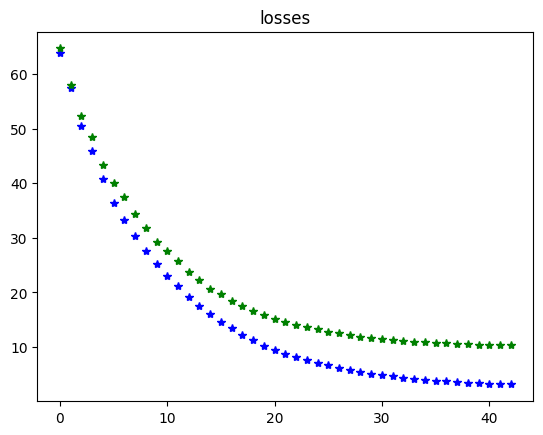

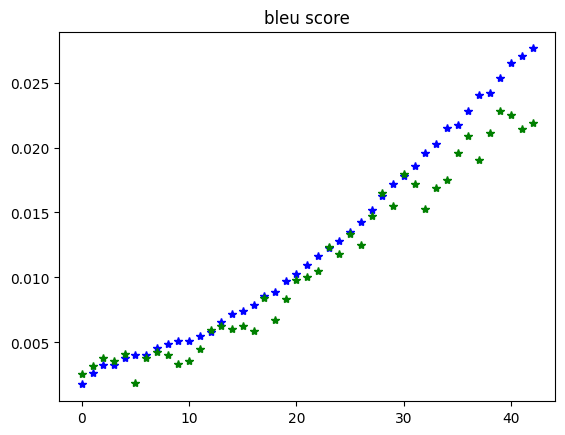

 10%|███████▏                                                                | 2/20 [07:11<1:04:44, 215.83s/it]

215.81736612319946
optimizing for epoch 2
training_step
0 2.8217564804591206
100 2.960196426642178
200 2.851390262394515
300 2.8846836873929793
400 2.996840508643617
500 3.0746910833543346
600 3.0759119064303952
700 2.925085683381985
800 3.3746563796680498
900 3.239392490554944
1000 2.9949054655481557
validation_step
0 10.103919043395196
100 8.069452798117155
saving for epoch 2


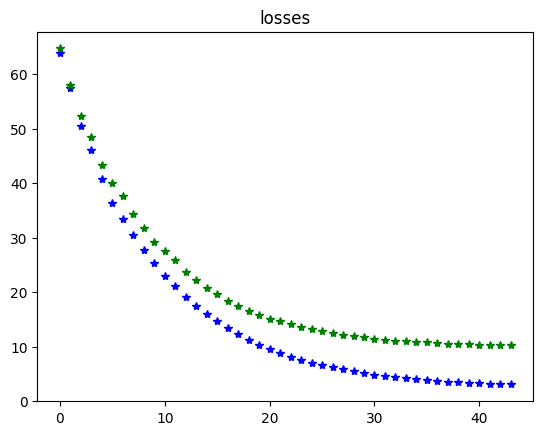

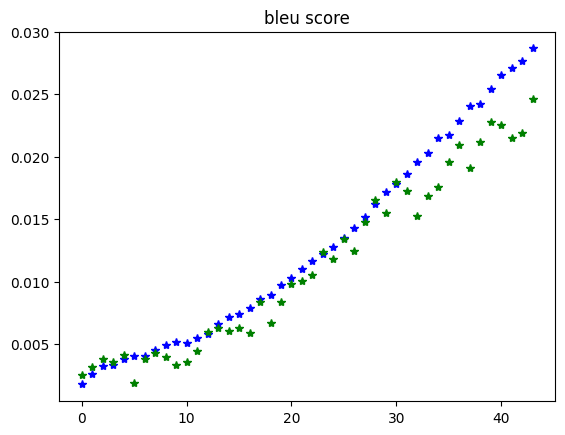

 15%|██████████▊                                                             | 3/20 [10:47<1:01:13, 216.06s/it]

216.33839178085327
optimizing for epoch 3
training_step
0 2.891719416221395
100 2.90389244626846
200 2.8347548393354023
300 2.7934210241501494
400 3.0253908333111137
500 2.9465304741240326
600 3.1113098559736394
700 2.8123779296875
800 3.1755199462504935
900 3.22504351801455
1000 3.2227662302815494
validation_step
0 11.986053618625622
100 10.39195068359375
saving for epoch 3


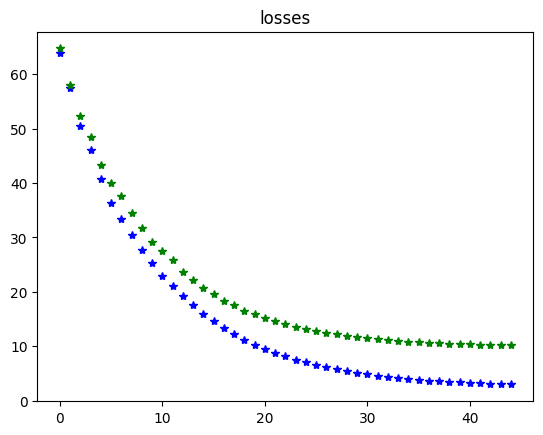

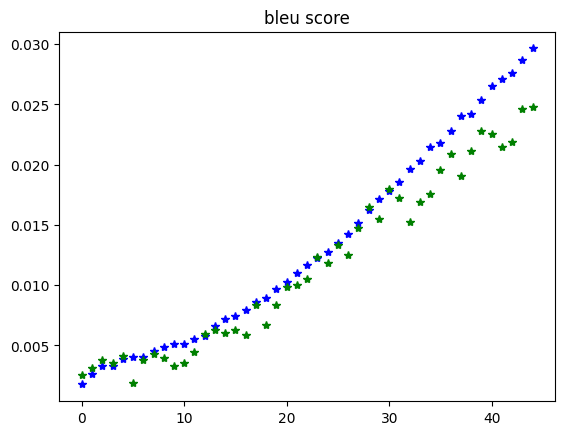

 20%|██████████████▊                                                           | 4/20 [14:24<57:37, 216.12s/it]

216.21368980407715
optimizing for epoch 4
training_step
0 3.0475016068967347
100 2.697556797969571
200 2.5868885128997094
300 2.87946047008547
400 2.974973553045698
500 3.122183143996578
600 3.087573989350703
700 2.8979159076802676
800 2.879268244693154
900 2.9003910578734486
1000 2.7652321706638627
validation_step
0 11.53836174141425
100 8.703414529586405
saving for epoch 4


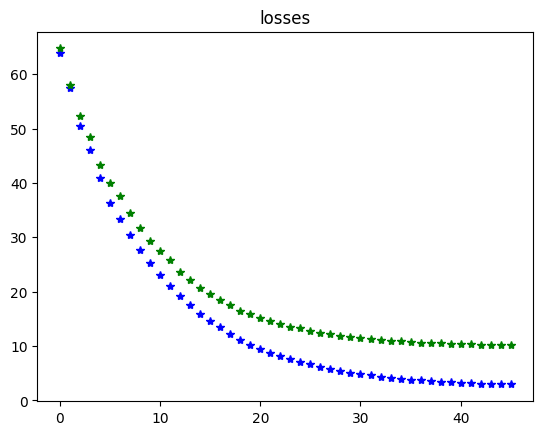

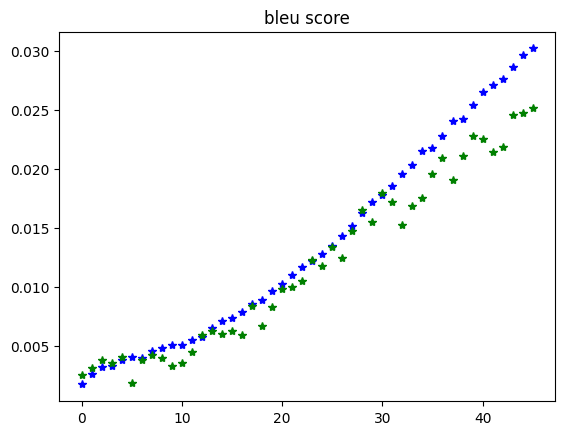

 25%|██████████████████▌                                                       | 5/20 [18:00<54:00, 216.06s/it]

215.9625015258789
optimizing for epoch 5
training_step
0 2.71334644942778
100 2.841379967621453
200 2.7004009824810606
300 2.8082862044327004
400 2.892013537287223
500 2.864041438500421
600 2.9663461234577264
700 2.9485885218570105
800 2.8137977687219617
900 2.7964583442476947
1000 2.8096457152240046
validation_step
0 10.638398570819113
100 10.590077329834605
saving for epoch 5


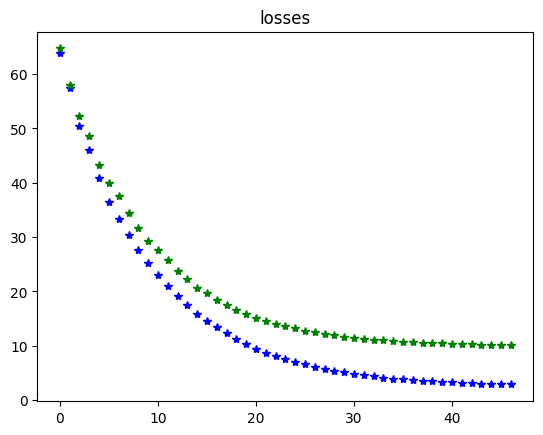

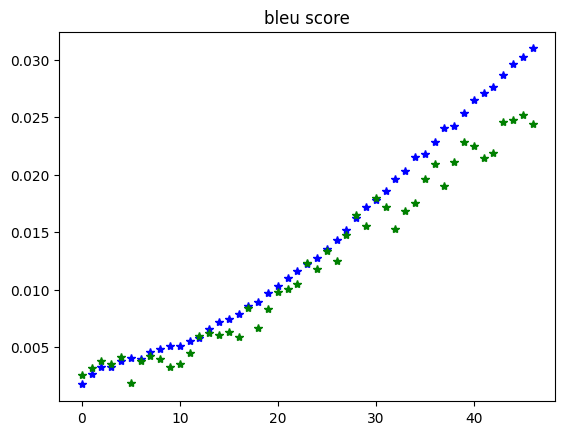

 30%|██████████████████████▏                                                   | 6/20 [21:36<50:24, 216.00s/it]

215.88325119018555
optimizing for epoch 6
training_step
0 2.6073268059424937
100 2.8500950590093086
200 2.790421251227094
300 2.6753212597237126
400 2.965778260522959
500 2.724870863572357
600 2.8511160714285713
700 2.8613694745872165
800 2.6606925937772212
900 2.6375288906647922
1000 2.926862416625494
validation_step
0 10.902490318128216
100 9.44781072287839
saving for epoch 6


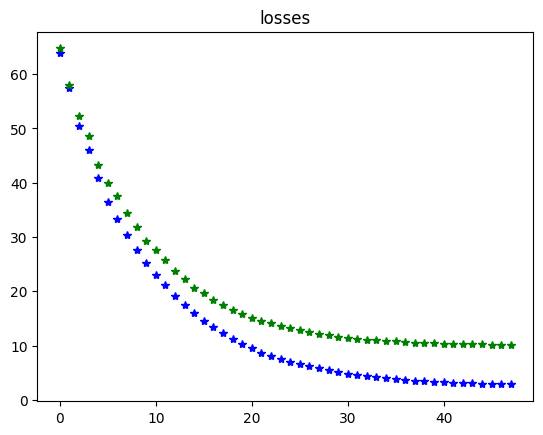

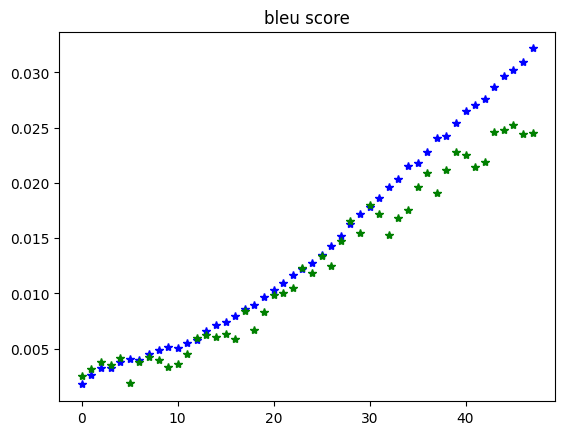

 35%|█████████████████████████▉                                                | 7/20 [25:12<46:49, 216.10s/it]

216.30035090446472
optimizing for epoch 7
training_step
0 2.7114624556495635
100 2.7001122217941593
200 2.6437549541863716
300 2.607097150592193
400 2.6840765544111305
500 2.649988779920213
600 2.7130699513623835
700 2.8358332127700616
800 2.8014912717671505
900 2.727568146366401
1000 2.834478759765625
validation_step
0 10.775180173285776
100 12.62986781409983
saving for epoch 7


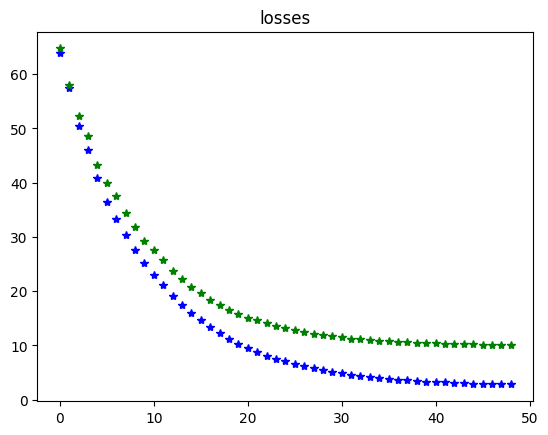

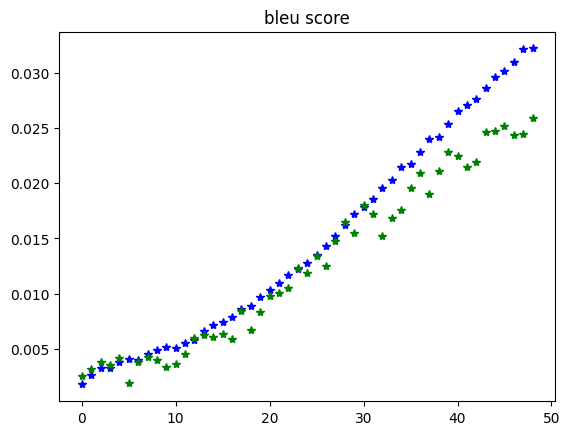

 40%|█████████████████████████████▌                                            | 8/20 [28:48<43:14, 216.18s/it]

216.36262249946594
optimizing for epoch 8
training_step
0 2.5011844234866696
100 2.746347742950464
200 2.755873371596028
300 2.4550081033909574
400 2.784650404676259
500 2.858215522171924
600 2.6379870760972333
700 2.805386536873427
800 2.9505371872507973
900 2.7576050989836167
1000 2.656905202353228
validation_step
0 10.56242950164069
100 8.619109042553191
saving for epoch 8


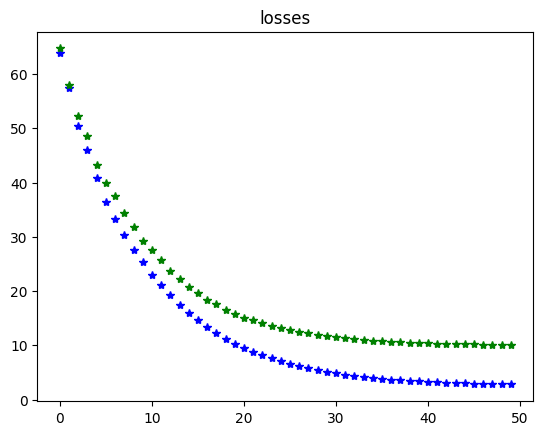

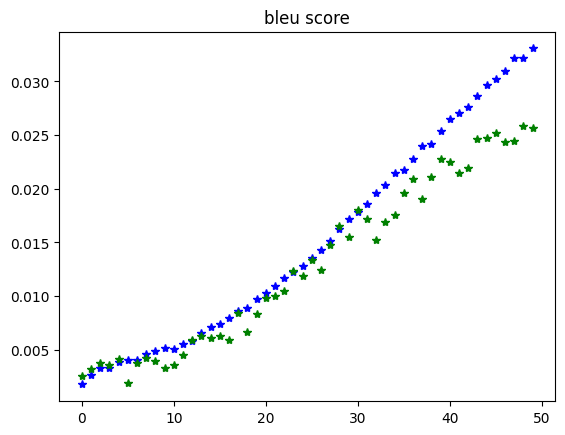

 45%|█████████████████████████████████▎                                        | 9/20 [32:24<39:38, 216.20s/it]

216.22200894355774
optimizing for epoch 9
training_step
0 2.6700757941100823
100 2.7366588445690008
200 2.524251089046139
300 2.83337645269745
400 2.639735399987087
500 2.7481947088960426
600 2.8268109790837177
700 2.7321446374869245
800 2.8681580713190185
900 2.7866260519267874
1000 2.996997170781893
validation_step
0 11.216054951882402
100 9.985669219154444
saving for epoch 9


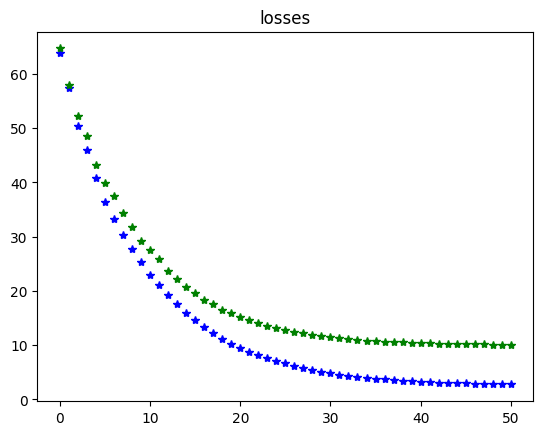

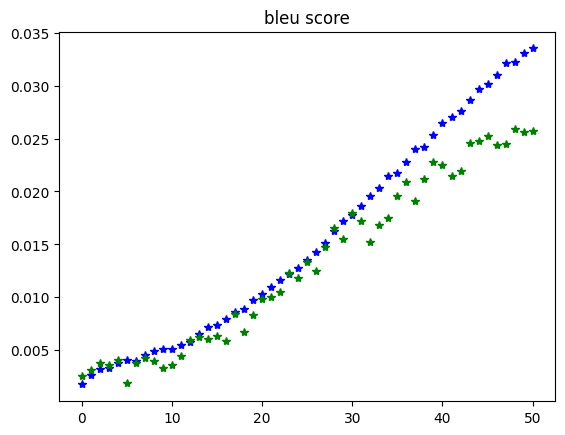

 50%|████████████████████████████████████▌                                    | 10/20 [36:01<36:02, 216.23s/it]

216.30540323257446
optimizing for epoch 10
training_step
0 2.650787405152813
100 2.620233682007035
200 2.7387360299635506
300 2.721216512209008
400 2.5325353695497146
500 2.5951535582444625
600 2.5956129717040426
700 2.5625050251929675
800 2.723755966918295
900 2.674728125
1000 2.825749089773216
validation_step
0 10.12860882787052
100 9.53129925271739
saving for epoch 10


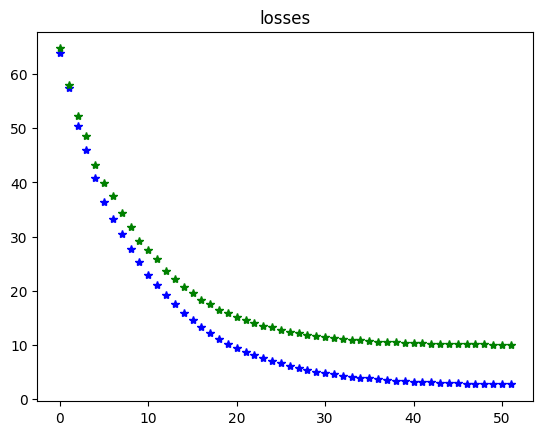

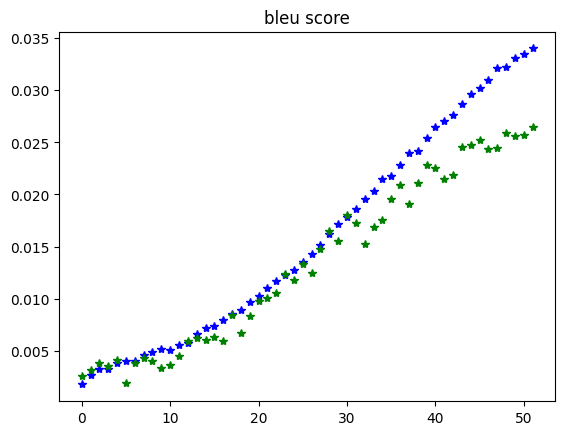

 55%|████████████████████████████████████████▏                                | 11/20 [39:37<32:26, 216.33s/it]

216.55447673797607
optimizing for epoch 11
training_step
0 2.6389833508593106
100 2.611486655257323
200 2.640350057551863
300 2.80454626506506
400 2.745837680010004
500 2.6648840168178483
600 2.87908015583158
700 2.5306022330506206
800 2.7061583773399143
900 2.68994140625
1000 2.823638041144077
validation_step
0 9.83763753463342
100 9.696786120046976
saving for epoch 11


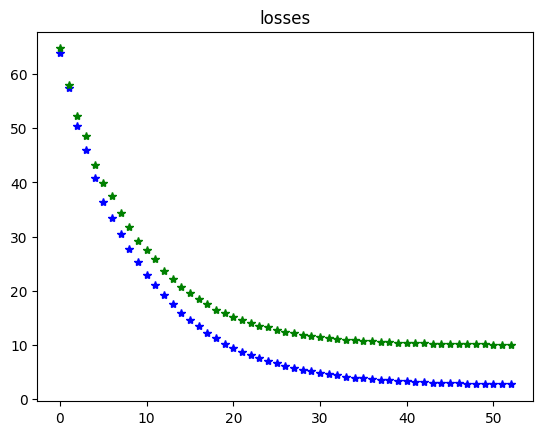

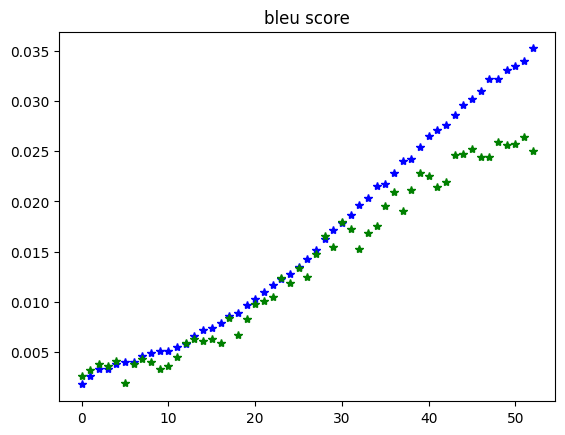

 60%|███████████████████████████████████████████▊                             | 12/20 [43:14<28:50, 216.35s/it]

216.39150595664978
optimizing for epoch 12
training_step
0 2.639041699861225
100 2.806107215341382
200 2.7031576455470674
300 2.744116776826366
400 2.717191390687251
500 2.626426678334005
600 2.6725343234204164
700 2.822157338418968
800 2.762064309176089
900 2.8127703368925903
1000 2.930120357951078
validation_step
0 10.866914599903268
100 9.13449127553502
saving for epoch 12


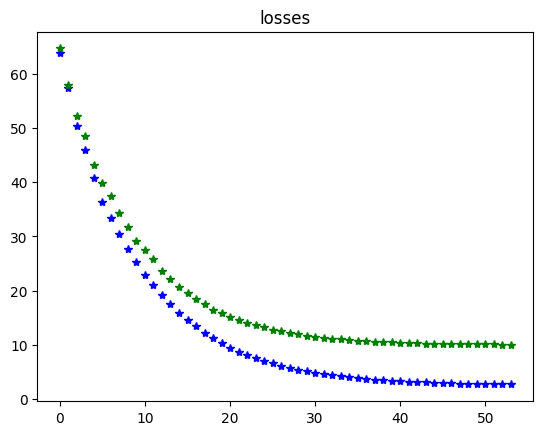

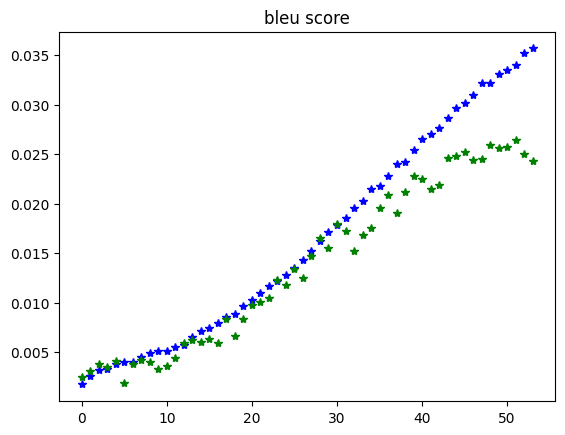

 65%|███████████████████████████████████████████████▍                         | 13/20 [46:50<25:14, 216.30s/it]

216.19462728500366
optimizing for epoch 13
training_step
0 2.5771727320809545
100 2.6127721601397678
200 2.7026158774771343
300 2.6170137221631022
400 2.8501428212249573
500 2.6689541520743534
600 2.7754825058803765
700 2.678469623979012
800 2.4431894929508284
900 2.838374782252956
1000 2.747035494132384
validation_step
0 10.458250758309543
100 12.009800942230866
saving for epoch 13


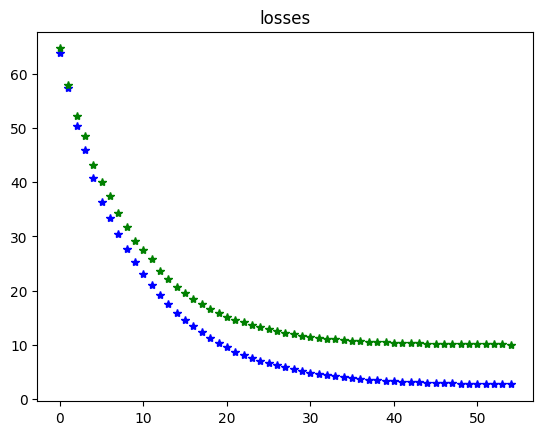

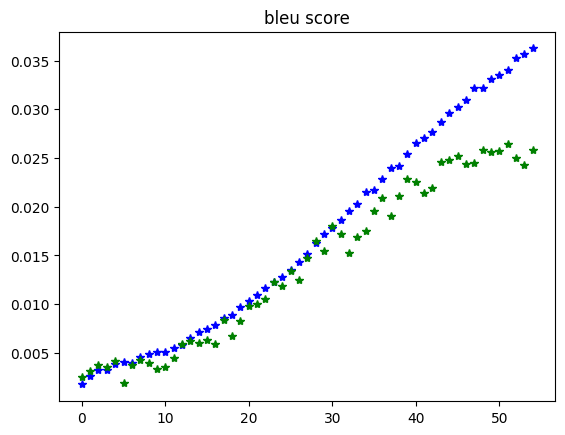

 70%|███████████████████████████████████████████████████                      | 14/20 [50:26<21:38, 216.37s/it]

216.50878405570984
optimizing for epoch 14
training_step
0 2.6830570954170194
100 2.8177681576775986
200 2.659187256247516
300 2.6438699144167663
400 2.5576487030712136
500 2.647249141123803
600 2.828043961725315
700 2.6479488031914893
800 2.6175395022435217
900 2.7218021702122046
1000 2.7703594970703125
validation_step
0 12.098190161026201
100 10.961081136411666
saving for epoch 14


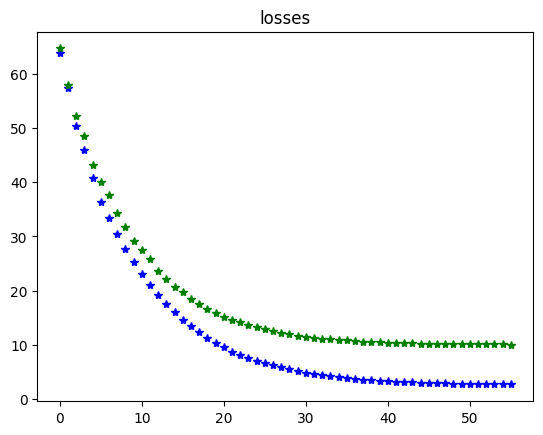

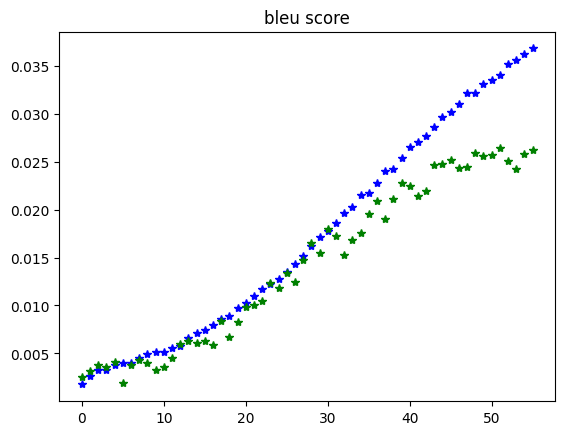

 75%|██████████████████████████████████████████████████████▊                  | 15/20 [54:02<18:00, 216.19s/it]

215.79100728034973
optimizing for epoch 15
training_step
0 2.60749856411863
100 2.6304894398834744
200 2.6432707594523253
300 2.779860879010695
400 2.7595117272344702
500 2.408959822781932
600 2.746986009247449
700 2.5859698391506543
800 2.6368814402613148
900 2.6883770001687086
1000 2.5217121987912487
validation_step
0 11.788487955729167
100 8.719146523699665
saving for epoch 15


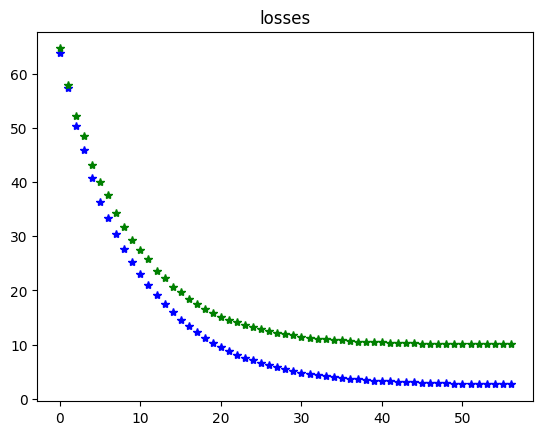

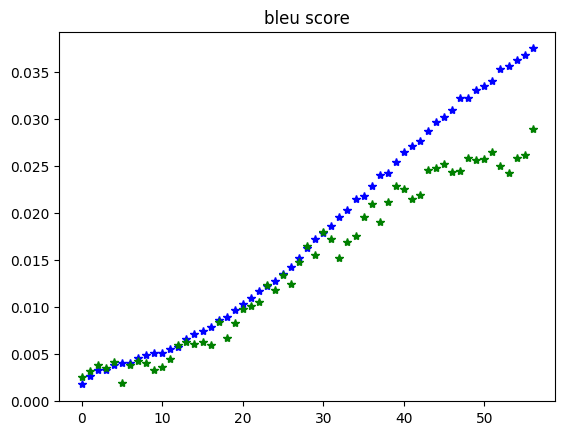

 80%|██████████████████████████████████████████████████████████▍              | 16/20 [57:38<14:23, 215.95s/it]

215.37906074523926
optimizing for epoch 16
training_step
0 2.427940595004363
100 2.4442045091567293
200 2.686521040047054
300 2.6572320976720647
400 2.5758344283409658
500 2.5411052541391608
600 2.516200488850437
700 2.5293624890509068
800 2.640445923746944
900 2.4940362745715725
1000 2.64487593089879
validation_step
0 9.884027487458194
100 10.713718276116259
saving for epoch 16


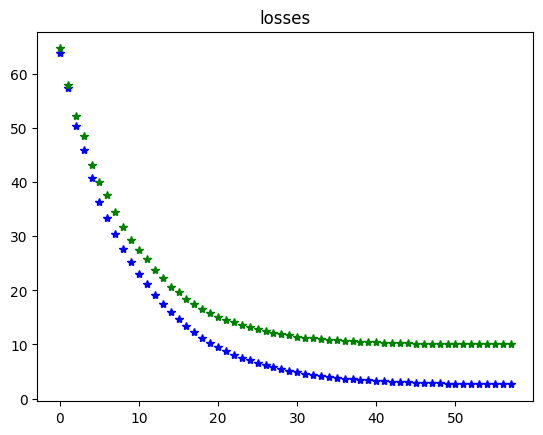

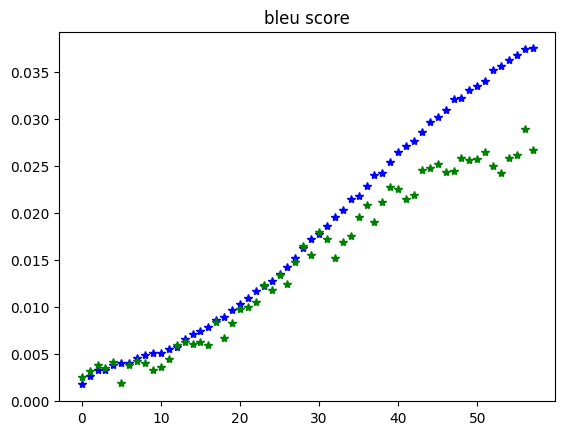

 85%|████████████████████████████████████████████████████████████▎          | 17/20 [1:01:13<10:47, 215.74s/it]

215.24253153800964
optimizing for epoch 17
training_step
0 2.4205569217079566
100 2.4255888904785987
200 2.5117075973966987
300 2.6629838351757655
400 2.4175238153737064
500 2.74709008097166
600 2.5979990100369856
700 2.642205689215104
800 2.7215916737788866
900 2.742120309161325
1000 2.7300133910438666
validation_step
0 9.7711231033237
100 8.284310659838642
saving for epoch 17


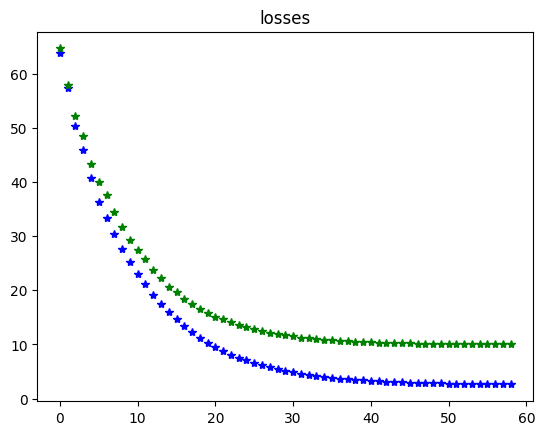

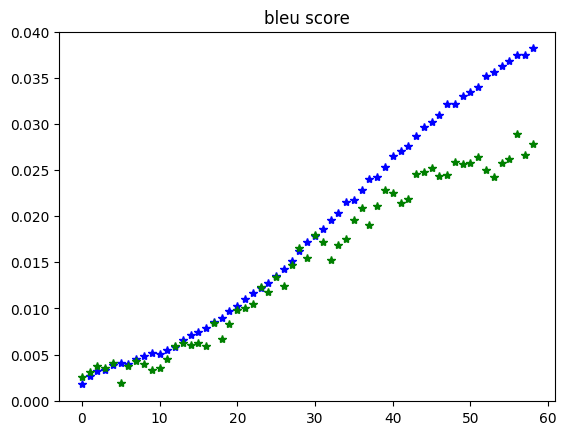

 90%|███████████████████████████████████████████████████████████████▉       | 18/20 [1:04:48<07:11, 215.51s/it]

214.99333691596985
optimizing for epoch 18
training_step
0 2.5884983707922826
100 2.611917615814084
200 2.6522220825598186
300 2.5293354996166455
400 2.5812929603674895
500 2.541360700786307
600 2.550873833733636
700 2.583060053116911
800 2.359753092027347
900 2.531473828125
1000 2.5714734686390095
validation_step
0 8.716088340847843
100 9.264412381001655
saving for epoch 18


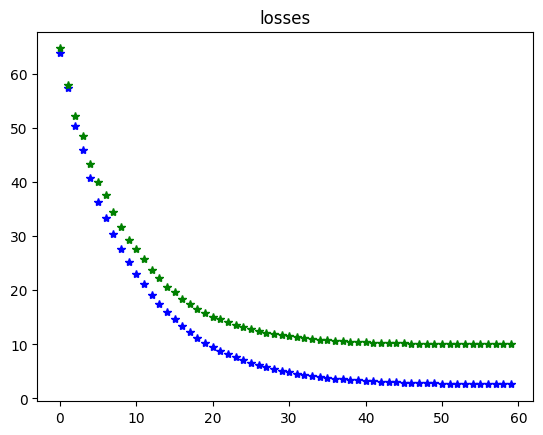

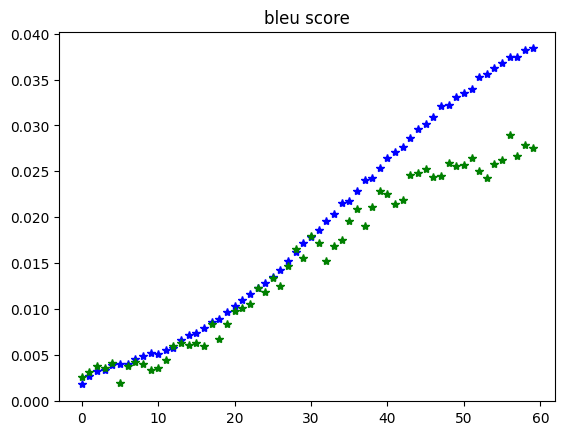

 95%|███████████████████████████████████████████████████████████████████▍   | 19/20 [1:08:23<03:35, 215.35s/it]

214.96512150764465
optimizing for epoch 19
training_step
0 2.590942086285425
100 2.645264682390832
200 2.8757277541822526
300 2.563216245164015
400 2.416708354077308
500 2.6522555714450244
600 2.587037380549936
700 2.3074662642045456
800 2.636011962890625
900 2.5704613375376506
1000 2.6342170039986854
validation_step
0 10.661505590841161
100 10.379513624237806
saving for epoch 19


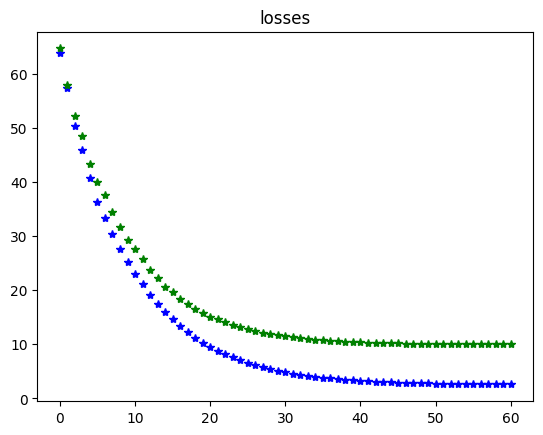

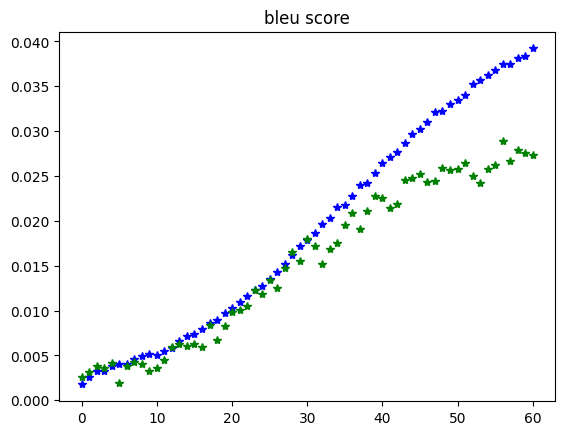

100%|███████████████████████████████████████████████████████████████████████| 20/20 [1:11:58<00:00, 215.91s/it]

214.84134221076965


In [38]:
import matplotlib.pyplot as plt
early_stop_thresh = 3
nb_epochs = 20

best_loss_val_mean = np.inf
best_epoch = scheduler.last_epoch

for epoch in tqdm(range(nb_epochs)):
    import time
    start = time.time()
    print(f"optimizing for epoch {epoch}")
    print("training_step")
    loss_train,nb_words_per_batch_train,metric_train = model_trainer.train_on_epoch()
    print("validation_step")
    loss_val,nb_words_per_batch_val,metric_val = model_trainer.validate_on_epoch()


    loss_train = np.array([float(el) for el in loss_train])
    loss_val = np.array([float(el) for el in loss_val])
    train_weights = 1/sum(nb_words_per_batch_train)
    val_weights = 1/sum(nb_words_per_batch_val)
    
    
        
    losses_on_train.append(np.sum(loss_train)/sum(nb_words_per_batch_train))
    losses_on_val.append(np.sum(loss_val)/sum(nb_words_per_batch_val))
    metrics_on_train.append(metric_train)
    metrics_on_val.append(metric_val)
    
    current_loss_val_mean = np.mean(loss_val)
    
    if (current_loss_val_mean < best_loss_val_mean) and (epoch-best_epoch<5):
        best_epoch = scheduler.last_epoch
        best_loss_val_mean = current_loss_val_mean

        state_dict_extended = {"model_params":model_trainer.model.state_dict(),
                               "model_inputs":model_inputs,
                              "optimizer":optimizer.state_dict(),
                              "scheduler":scheduler.state_dict(),
                              "losses_with_weights":{"train":losses_on_train,"val":losses_on_val},
                              "metrics":{"train":metrics_on_train,"val":metrics_on_val}
                              }
        
        torch.save(state_dict_extended,path_model_and_dependencies)
        print(f"saving for epoch {epoch}")

        plt.plot(losses_on_train,"b*")
        plt.plot(losses_on_val,"g*")
        plt.title("losses")
        plt.show()        
        plt.figure()
        plt.plot(metrics_on_train,"b*")
        plt.plot(metrics_on_val,"g*")
        plt.title("bleu score")
        plt.show()
    elif epoch - best_epoch > early_stop_thresh:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop
    stop = time.time()
    print(stop-start)